#Stock Market Prediction using Numerical and Textual Analysis

By Nikhil Jindal

Datasets used 
- Historical stock prices: https://finance.yahoo.com/ 
- Textual News Headlines: https://bit.ly/36fFPI6

Stock to analyze and predict: SENSEX (S&P BSE SENSEX)

Date: 01-01-2001 to 30-06-2020

##Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
%matplotlib inline

from datetime import datetime, timedelta,date

from textblob import TextBlob

import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

#Sentiment Processing and Analysis

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Reading Textual News Headlines Data
df1 = pd.read_csv("/content/drive/MyDrive/Stock prediction/india-news-headlines.csv")
df1.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [4]:
#Checking the shape (num of rows and columns) of dataset
df1.shape

(3424067, 3)

In [5]:
#Extracting other info 
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424067 entries, 0 to 3424066
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   publish_date       int64 
 1   headline_category  object
 2   headline_text      object
dtypes: int64(1), object(2)
memory usage: 78.4+ MB


In [6]:
#Transforming "publish_date" attribute to proper 'date' Dtype
df1['publish_date'] = df1['publish_date'].apply(lambda x: str(x))
df1['publish_date'] = df1['publish_date'].apply(lambda x: date(year= int(x[0:4]), month= int(x[4:6]), day= int(x[6:8])))
df1 = df1.sort_values(by='publish_date')

In [7]:
df1["publish_date"]= pd.to_datetime(df1["publish_date"])

In [8]:
df1.head()

,publish_date,headline_category,headline_text
0,2001-01-02,unknown,Status quo will not be disturbed at Ayodhya; s...
63,2001-01-02,unknown,Petition over ministers' assets dismissed
62,2001-01-02,unknown,Bomb hoax triggers panic in Canara Bank
61,2001-01-02,unknown,Consul is back from month-long leave
60,2001-01-02,unknown,Redemption night; amid some rock


In [9]:
#Joining different news headlines of a common date into single string using 'groupby' function
df1 = df1.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

In [10]:
df1.head()

,publish_date,headline_text
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,"Tumkur gets 243 borewells,It's shopping time f..."
2,2001-01-04,"Right choice is the key; says Iranian coach,Ra..."
3,2001-01-05,"Philippine soldiers arrest bombing suspects,Ch..."
4,2001-01-06,Australia; New Zealand urged to accept Indo-Fi...


You can see all the news for the date '2001-01-02' have been combined into one single string

In [11]:
df1['headline_text'][0]

"Status quo will not be disturbed at Ayodhya; says Vajpayee,Petition over ministers' assets dismissed,Bomb hoax triggers panic in Canara Bank,Consul is back from month-long leave,Redemption night; amid some rock,The best music of the year,A noisy effort to spruce up Commercial Street,Home is where the holistic science is,Promises to keep,He beat polio; but a truck driver's is no life,Fashion in the future,HAL approached for super jumbo project,Mafia calls the shots in Gandhinagar too,Moves afoot to evict squatters in Urban dist,Park turns temple compound as residents watch,This official has sued the briber,State may take AP to court over Krishna,America's unwanted heading for India?,BJP jumps into rail track conversion issue,Nagathihalli returns with Preethiya Hudugi,Hoshangabad farmers have enough water,Destroying myths and doubts on sexuality,More engg colleges if needed in state: Govt,Raju Chacha,VIPs suffer as power supply is stopped to govt guest houses,Cactus which made it to Gui

Now I will check the polarity/sentiment score of each 'headline_text' and insert it to a new column called 'sentiment' in the dataframe.

I will be using "TextBlob" library for the same purpose

In [12]:
#Here's a demo of "TextBlob" library
sentence = '''The platform provides universal access to the world's best education, partnering with top universities and organizations to offer courses online.'''

# Creating a textblob object and assigning the sentiment property
analysis = TextBlob(sentence).polarity
print(analysis)

0.5


In [13]:
#Using apply function to implement TextBlob function
df1['sentiment'] = df1['headline_text'].apply(lambda x: TextBlob(x).polarity )

In [14]:
#Renaming the 'publish_date' attribute to 'date'
df1 = df1.rename(columns={'publish_date': 'Date'})

In [15]:
df1.head(10)

,Date,headline_text,sentiment
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...,0.113725
1,2001-01-03,"Tumkur gets 243 borewells,It's shopping time f...",0.141667
2,2001-01-04,"Right choice is the key; says Iranian coach,Ra...",0.136633
3,2001-01-05,"Philippine soldiers arrest bombing suspects,Ch...",0.250480
4,2001-01-06,Australia; New Zealand urged to accept Indo-Fi...,0.229545
5,2001-01-07,"Aamir Khan: 'Lagaan' ko zabaan do,Need for far...",-0.037689
6,2001-01-08,Paramour; accomplice get life term for killing...,-0.017149
7,2001-01-09,"50 handicaps to get artificial limbs,Hefty pho...",-0.059579
8,2001-01-10,"State police collapses under pressure,Court de...",0.000000
9,2001-01-23,Way2Wealth positions as one-stop financial sho...,0.041335


In [16]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7262 entries, 0 to 7261
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           7262 non-null   datetime64[ns]
 1   headline_text  7262 non-null   object        
 2   sentiment      7262 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 170.3+ KB


#Stock Data Processing and Analysis

In [17]:
#Reading historical stock data
df2 = pd.read_csv('/content/drive/MyDrive/Stock prediction/AAPL.csv')
df2.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,0.265625,0.272321,0.260045,0.265625,0.229537,452312000
1,2001-01-03,0.258929,0.297991,0.257813,0.292411,0.252684,817073600
2,2001-01-04,0.323940,0.330357,0.300223,0.304688,0.263292,739396000
3,2001-01-05,0.302455,0.310268,0.286830,0.292411,0.252684,412356000
4,2001-01-08,0.302455,0.303292,0.284598,0.295759,0.255577,373699200


In [18]:
#Checking other info
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4904 entries, 0 to 4903
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4904 non-null   object 
 1   Open       4904 non-null   float64
 2   High       4904 non-null   float64
 3   Low        4904 non-null   float64
 4   Close      4904 non-null   float64
 5   Adj Close  4904 non-null   float64
 6   Volume     4904 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 268.3+ KB


In [19]:
#Converting "Date" Dtype from object to datetime
df2["Date"]= pd.to_datetime(df2["Date"])

In [20]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4904 entries, 0 to 4903
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       4904 non-null   datetime64[ns]
 1   Open       4904 non-null   float64       
 2   High       4904 non-null   float64       
 3   Low        4904 non-null   float64       
 4   Close      4904 non-null   float64       
 5   Adj Close  4904 non-null   float64       
 6   Volume     4904 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 268.3 KB


In [21]:
#Sorting values by "Date"
df2 = df2.sort_values(by='Date')
df2.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,0.265625,0.272321,0.260045,0.265625,0.229537,452312000
1,2001-01-03,0.258929,0.297991,0.257813,0.292411,0.252684,817073600
2,2001-01-04,0.323940,0.330357,0.300223,0.304688,0.263292,739396000
3,2001-01-05,0.302455,0.310268,0.286830,0.292411,0.252684,412356000
4,2001-01-08,0.302455,0.303292,0.284598,0.295759,0.255577,373699200


#Merging both the dataframes (Textual and Stock)

In [22]:
#Performing left join on "Date" attribute
data = pd.merge(df2, df1, how='left', on=['Date'])

In [23]:
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4904 entries, 0 to 4903
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           4904 non-null   datetime64[ns]
 1   Open           4904 non-null   float64       
 2   High           4904 non-null   float64       
 3   Low            4904 non-null   float64       
 4   Close          4904 non-null   float64       
 5   Adj Close      4904 non-null   float64       
 6   Volume         4904 non-null   int64         
 7   headline_text  4876 non-null   object        
 8   sentiment      4876 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 383.1+ KB
None


,Date,Open,High,Low,Close,Adj Close,Volume,headline_text,sentiment
0,2001-01-02,0.265625,0.272321,0.260045,0.265625,0.229537,452312000,Status quo will not be disturbed at Ayodhya; s...,0.113725
1,2001-01-03,0.258929,0.297991,0.257813,0.292411,0.252684,817073600,"Tumkur gets 243 borewells,It's shopping time f...",0.141667
2,2001-01-04,0.323940,0.330357,0.300223,0.304688,0.263292,739396000,"Right choice is the key; says Iranian coach,Ra...",0.136633
3,2001-01-05,0.302455,0.310268,0.286830,0.292411,0.252684,412356000,"Philippine soldiers arrest bombing suspects,Ch...",0.250480
4,2001-01-08,0.302455,0.303292,0.284598,0.295759,0.255577,373699200,Paramour; accomplice get life term for killing...,-0.017149


In [24]:
#Saving the combined dataset on drive
data.to_csv('/content/drive/MyDrive/Stock prediction/data.csv',index=False)

#Hybrid

In [25]:
#Reading hybrid dataset
df = pd.read_csv('/content/drive/MyDrive/Stock prediction/data.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,headline_text,sentiment
0,2001-01-02,0.265625,0.272321,0.260045,0.265625,0.229537,452312000,Status quo will not be disturbed at Ayodhya; s...,0.113725
1,2001-01-03,0.258929,0.297991,0.257813,0.292411,0.252684,817073600,"Tumkur gets 243 borewells,It's shopping time f...",0.141667
2,2001-01-04,0.323940,0.330357,0.300223,0.304688,0.263292,739396000,"Right choice is the key; says Iranian coach,Ra...",0.136633
3,2001-01-05,0.302455,0.310268,0.286830,0.292411,0.252684,412356000,"Philippine soldiers arrest bombing suspects,Ch...",0.250480
4,2001-01-08,0.302455,0.303292,0.284598,0.295759,0.255577,373699200,Paramour; accomplice get life term for killing...,-0.017149


In [26]:
#Dropping "headline_text" attribute (it is not required for modeling)
df.drop('headline_text', inplace=True, axis=1)

In [27]:
#Dropping null values
df = df.dropna(how ='all')

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4904 entries, 0 to 4903
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4904 non-null   object 
 1   Open       4904 non-null   float64
 2   High       4904 non-null   float64
 3   Low        4904 non-null   float64
 4   Close      4904 non-null   float64
 5   Adj Close  4904 non-null   float64
 6   Volume     4904 non-null   int64  
 7   sentiment  4876 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 344.8+ KB


In [29]:
#dropping rows where 'sentiment' has null values 
df = df.dropna(axis=0, subset=['sentiment'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4876 entries, 0 to 4903
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4876 non-null   object 
 1   Open       4876 non-null   float64
 2   High       4876 non-null   float64
 3   Low        4876 non-null   float64
 4   Close      4876 non-null   float64
 5   Adj Close  4876 non-null   float64
 6   Volume     4876 non-null   int64  
 7   sentiment  4876 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 342.8+ KB


In [30]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,sentiment
0,2001-01-02,0.265625,0.272321,0.260045,0.265625,0.229537,452312000,0.113725
1,2001-01-03,0.258929,0.297991,0.257813,0.292411,0.252684,817073600,0.141667
2,2001-01-04,0.323940,0.330357,0.300223,0.304688,0.263292,739396000,0.136633
3,2001-01-05,0.302455,0.310268,0.286830,0.292411,0.252684,412356000,0.250480
4,2001-01-08,0.302455,0.303292,0.284598,0.295759,0.255577,373699200,-0.017149
...,...,...,...,...,...,...,...,...
4899,2020-06-24,91.250000,92.197502,89.629997,90.014999,89.852997,192623200,0.097046
4900,2020-06-25,90.175003,91.250000,89.392502,91.209999,91.045845,137522400,0.018331
4901,2020-06-26,91.102501,91.330002,88.254997,88.407501,88.248390,205256800,0.084044
4902,2020-06-29,88.312500,90.542503,87.820000,90.445000,90.282219,130646000,0.049375


In [31]:
#Setting 'Date' as index for the dataframe
df.set_index('Date', inplace=True)

In [32]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,sentiment
Date,,,,,,,
2001-01-02,0.265625,0.272321,0.260045,0.265625,0.229537,452312000,0.113725
2001-01-03,0.258929,0.297991,0.257813,0.292411,0.252684,817073600,0.141667
2001-01-04,0.323940,0.330357,0.300223,0.304688,0.263292,739396000,0.136633
2001-01-05,0.302455,0.310268,0.286830,0.292411,0.252684,412356000,0.250480
2001-01-08,0.302455,0.303292,0.284598,0.295759,0.255577,373699200,-0.017149


Text(0, 0.5, 'Close Price ($)')

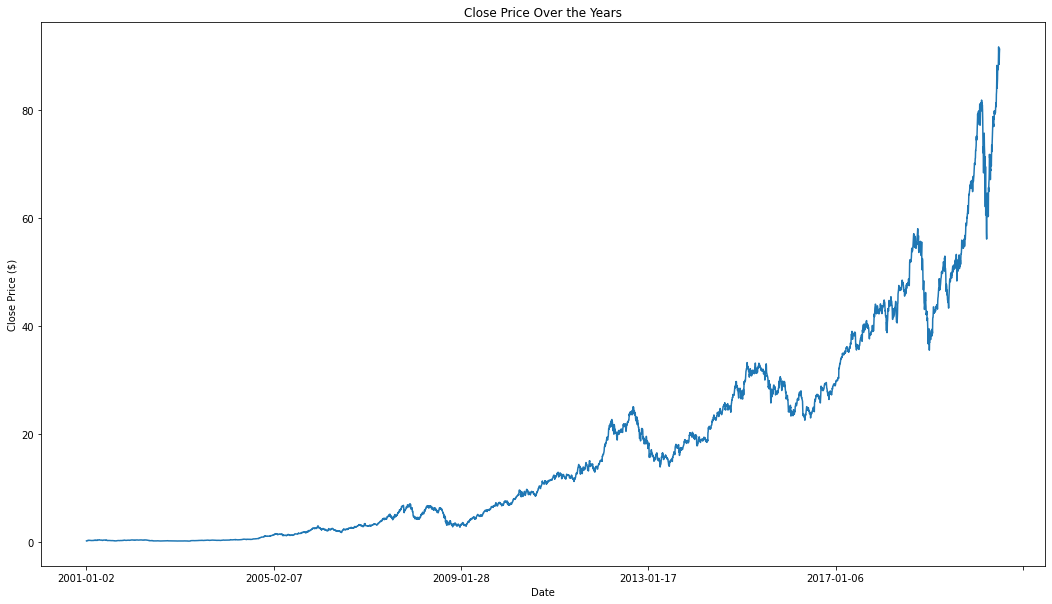

In [33]:
plt.figure(figsize=(18,10))

# plotting close price
df['Close'].plot()

# setting plot title, x and y labels
plt.title("Close Price Over the Years")
plt.xlabel('Date')
plt.ylabel('Close Price ($)')

##Feature Engineering

**Note: I will be predicting the close price of the next day using the attributes of the present day.
For example: I will try to predict the close price of '2001-01-03' using the attributes of '2001-01-02'**

This is because I'm assuming that the price of a stock fluctuates because of the previous day stock result and events that occurred in the market.

In [34]:
#Preparing the "target_close" attribute by shifting the close price of subsequent days
df['target_close'] = df.Close.shift(-1)

In [35]:
df = df.dropna(axis=0, subset=['target_close'])
df

,Open,High,Low,Close,Adj Close,Volume,sentiment,target_close
Date,,,,,,,,
2001-01-02,0.265625,0.272321,0.260045,0.265625,0.229537,452312000,0.113725,0.292411
2001-01-03,0.258929,0.297991,0.257813,0.292411,0.252684,817073600,0.141667,0.304688
2001-01-04,0.323940,0.330357,0.300223,0.304688,0.263292,739396000,0.136633,0.292411
2001-01-05,0.302455,0.310268,0.286830,0.292411,0.252684,412356000,0.250480,0.295759
2001-01-08,0.302455,0.303292,0.284598,0.295759,0.255577,373699200,-0.017149,0.306920
...,...,...,...,...,...,...,...,...
2020-06-23,91.000000,93.095001,90.567497,91.632500,91.467583,212155600,0.073625,90.014999
2020-06-24,91.250000,92.197502,89.629997,90.014999,89.852997,192623200,0.097046,91.209999
2020-06-25,90.175003,91.250000,89.392502,91.209999,91.045845,137522400,0.018331,88.407501


###Scaling the dataframe

Since I am using LSTM to predict stock prices, which is a time series data, it is important to understand that LSTM can be very sensitive to the scale of the data. Right now, if the data is observed, it is present in different scales. Therefore, it is important to re-scale the data so that the range of the dataset is same, for almost all records. 

In [36]:
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [37]:
print(df)

                Open      High       Low     Close  Adj Close    Volume  \
Date                                                                      
2001-01-02  0.000370  0.000396  0.000364  0.000343   0.000297  0.125682   
2001-01-03  0.000296  0.000673  0.000339  0.000636   0.000550  0.234876   
2001-01-04  0.001011  0.001021  0.000809  0.000770   0.000667  0.211623   
2001-01-05  0.000774  0.000805  0.000661  0.000636   0.000550  0.113721   
2001-01-08  0.000774  0.000730  0.000636  0.000673   0.000582  0.102149   
...              ...       ...       ...       ...        ...       ...   
2020-06-23  0.997253  1.000000  1.000000  1.000000   1.000000  0.053790   
2020-06-24  1.000000  0.990335  0.989623  0.982303   0.982309  0.047943   
2020-06-25  0.988189  0.980131  0.986994  0.995377   0.995379  0.031448   
2020-06-26  0.998379  0.980993  0.974402  0.964715   0.964727  0.051725   
2020-06-29  0.967726  0.972512  0.969587  0.987007   0.987012  0.029390   

            sentiment  t

###Feature Extraction

Selecting features for the training purpose that are sufficiently correlated with the target attribute 'target_close'

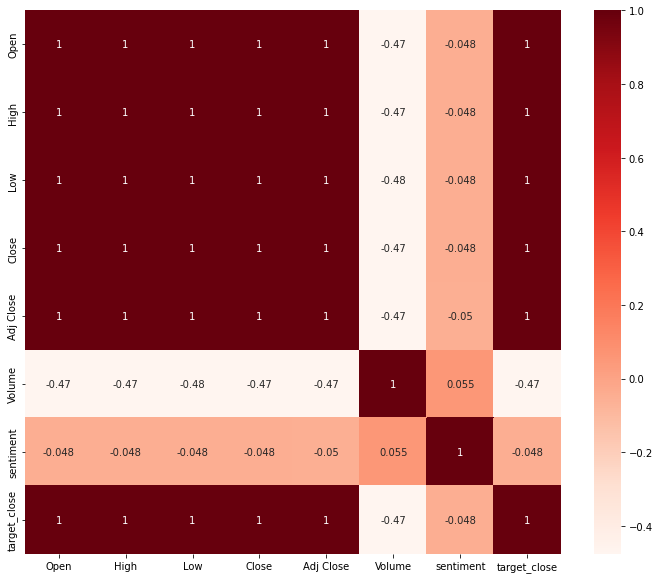

In [38]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [39]:
#Correlation with output variable
cor_target = abs(cor["target_close"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.4]
relevant_features

Open            0.999508
High            0.999580
Low             0.999581
Close           0.999630
Adj Close       0.998724
Volume          0.473886
target_close    1.000000
Name: target_close, dtype: float64

The above attributes are strongly correlated with 'target_close'. But we have to also check if those attributes are correlated to each other or not. If yes then we have to eliminate some of them and select only the best features.

In [40]:
print(df[["Open","High"]].corr())
print(df[["Open","Low"]].corr())
print(df[["Open","Adj Close"]].corr())
print(df[["Open","Volume"]].corr())
print(df[["Open","Close"]].corr())
print("-------------")
print(df[["High","Low"]].corr())
print(df[["High","Adj Close"]].corr())
print(df[["High","Volume"]].corr())
print(df[["High","Close"]].corr())
print("-------------")
print(df[["Low","Adj Close"]].corr())
print(df[["Low","Volume"]].corr())
print(df[["Low","Close"]].corr())
print("-------------")
print(df[["Volume","Close"]].corr())


          Open      High
Open  1.000000  0.999907
High  0.999907  1.000000
          Open       Low
Open  1.000000  0.999902
Low   0.999902  1.000000
               Open  Adj Close
Open       1.000000   0.998824
Adj Close  0.998824   1.000000
            Open    Volume
Open    1.000000 -0.473891
Volume -0.473891  1.000000
           Open     Close
Open   1.000000  0.999816
Close  0.999816  1.000000
-------------
          High       Low
High  1.000000  0.999846
Low   0.999846  1.000000
               High  Adj Close
High       1.000000   0.998991
Adj Close  0.998991   1.000000
            High    Volume
High    1.000000 -0.472208
Volume -0.472208  1.000000
           High     Close
High   1.000000  0.999897
Close  0.999897  1.000000
-------------
                Low  Adj Close
Low        1.000000   0.998895
Adj Close  0.998895   1.000000
             Low    Volume
Low     1.000000 -0.476037
Volume -0.476037  1.000000
            Low     Close
Low    1.000000  0.999902
Close  0.999902  

The attributes 'Open', 'Close', 'Low', 'High', 'Adj Close' are strongly correlated to each other. Therefore, I will consider only 'Close' and 'Volume'

In [41]:
#Preparing dataframes for modelling
X = df[['Close','Volume']]
Y = df['target_close']

In [42]:
print(X)
Y

               Close    Volume
Date                          
2001-01-02  0.000343  0.125682
2001-01-03  0.000636  0.234876
2001-01-04  0.000770  0.211623
2001-01-05  0.000636  0.113721
2001-01-08  0.000673  0.102149
...              ...       ...
2020-06-23  1.000000  0.053790
2020-06-24  0.982303  0.047943
2020-06-25  0.995377  0.031448
2020-06-26  0.964715  0.051725
2020-06-29  0.987007  0.029390

[4875 rows x 2 columns]


Date
2001-01-02    0.000636
2001-01-03    0.000770
2001-01-04    0.000636
2001-01-05    0.000673
2001-01-08    0.000795
                ...   
2020-06-23    0.982303
2020-06-24    0.995377
2020-06-25    0.964715
2020-06-26    0.987007
2020-06-29    0.995268
Name: target_close, Length: 4875, dtype: float64

#Preparing Data for Training and Testing

Normally for any other dataset train_test_split from sklearn package is used, but for time series data like stock prices which is dependent on date, the dataset is divided into train and test dataset in a different way as shown below. In timeseries data, an observation for a particular date is always dependent on the previous date records.

In [43]:
#80% data for training and 20% for testing 
split = int(len(X-1)*0.8)

In [44]:
x_train = X.iloc[:split,:]
y_train = Y.iloc[:split]
x_test = X.iloc[split+1:,:]
y_test = Y.iloc[split+1:]

In [45]:
print(x_train)
print(y_train)
print(x_test)
print(y_test)

               Close    Volume
Date                          
2001-01-02  0.000343  0.125682
2001-01-03  0.000636  0.234876
2001-01-04  0.000770  0.211623
2001-01-05  0.000636  0.113721
2001-01-08  0.000673  0.102149
...              ...       ...
2016-08-08  0.293859  0.023852
2016-08-09  0.295063  0.021790
2016-08-10  0.292847  0.019028
2016-08-11  0.292656  0.023191
2016-08-12  0.293340  0.012624

[3900 rows x 2 columns]
Date
2001-01-02    0.000636
2001-01-03    0.000770
2001-01-04    0.000636
2001-01-05    0.000673
2001-01-08    0.000795
                ...   
2016-08-08    0.295063
2016-08-09    0.292847
2016-08-10    0.292656
2016-08-11    0.293340
2016-08-12    0.296895
Name: target_close, Length: 3900, dtype: float64
               Close    Volume
Date                          
2016-08-16  0.296622  0.030746
2016-08-17  0.296184  0.020642
2016-08-18  0.295801  0.016605
2016-08-19  0.296567  0.020656
2016-08-22  0.294242  0.021198
...              ...       ...
2020-06-23  1.000

In [46]:
x_train.shape

(3900, 2)

In [47]:
# reshaping the feature dataset for feeding into the model
x_train = x_train.to_numpy().reshape(x_train.shape + (1,)) 
x_test = x_test.to_numpy().reshape(x_test.shape + (1,))

# printing the re-shaped feature dataset
print('Shape of Training set X:', x_train.shape)
print('Shape of Test set X:', x_test.shape)

Shape of Training set X: (3900, 2, 1)
Shape of Test set X: (974, 2, 1)


#Training and Testing

In [48]:
# setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(2000)

# setting the model architecture
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(2,1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 100)            40800     
                                                                 
 dropout (Dropout)           (None, 2, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 2, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 2, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [49]:
# compiling the model
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
model.fit(x_train, y_train, validation_split=0.2, epochs=10, batch_size=8, verbose=1)

Epoch 1/10
390/390 [==============================] - 11s 16ms/step - loss: 9.1936e-04 - val_loss: 4.1338e-04
Epoch 2/10
390/390 [==============================] - 4s 11ms/step - loss: 6.5602e-05 - val_loss: 7.4632e-05
Epoch 3/10
390/390 [==============================] - 3s 8ms/step - loss: 6.2936e-05 - val_loss: 5.8047e-05
Epoch 4/10
390/390 [==============================] - 3s 8ms/step - loss: 4.0211e-05 - val_loss: 2.0636e-05
Epoch 5/10
390/390 [==============================] - 3s 8ms/step - loss: 4.3268e-05 - val_loss: 1.5747e-04
Epoch 6/10
390/390 [==============================] - 3s 8ms/step - loss: 3.3913e-05 - val_loss: 4.3114e-04
Epoch 7/10
390/390 [==============================] - 3s 8ms/step - loss: 3.9847e-05 - val_loss: 4.4955e-05
Epoch 8/10
390/390 [==============================] - 3s 8ms/step - loss: 3.8992e-05 - val_loss: 4.1930e-05
Epoch 9/10
390/390 [==============================] - 3s 8ms/step - loss: 4.3805e-05 - val_loss: 4.8509e-05
Epoch 10/10
390/390 [====

In [50]:
predictions = model.predict(x_test)

#converting 2d array to 1d array
predictions = predictions.flatten()


In [51]:
# printing the predictions
y_test = y_test.to_numpy()
print('Predictions:')
print(predictions[0:5])
print('------------')
print(y_test[0:5])

Predictions:
[0.29624698 0.2958714  0.29552078 0.2962384  0.29400718]
------------
[0.29618428 0.29580134 0.29656722 0.29424224 0.29517222]


In [52]:
# calculating the training mean-squared-error
train_loss = model.evaluate(x_train, y_train, batch_size = 1)

# calculating the test mean-squared-error
test_loss = model.evaluate(x_test, y_test, batch_size = 1)

# printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

974/974 [==============================] - 4s 3ms/step - loss: 0.0017
Train Loss = 0.0
Test Loss = 0.0017


In [53]:
# calculating root mean squared error
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 0.0413


In [54]:
# calculating root mean squared error using sklearn.metrics package

rmse = metrics.mean_squared_error(y_test, predictions)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse),4))

Root Mean Square Error (sklearn.metrics) = 0.0413


In [55]:
# calculating NRMSE Score

y = np.mean(y_test)
x = round(np.sqrt(rmse),4)
print('NRMSE Score: ', str((x/y)))

NRMSE Score:  0.07939421526799827


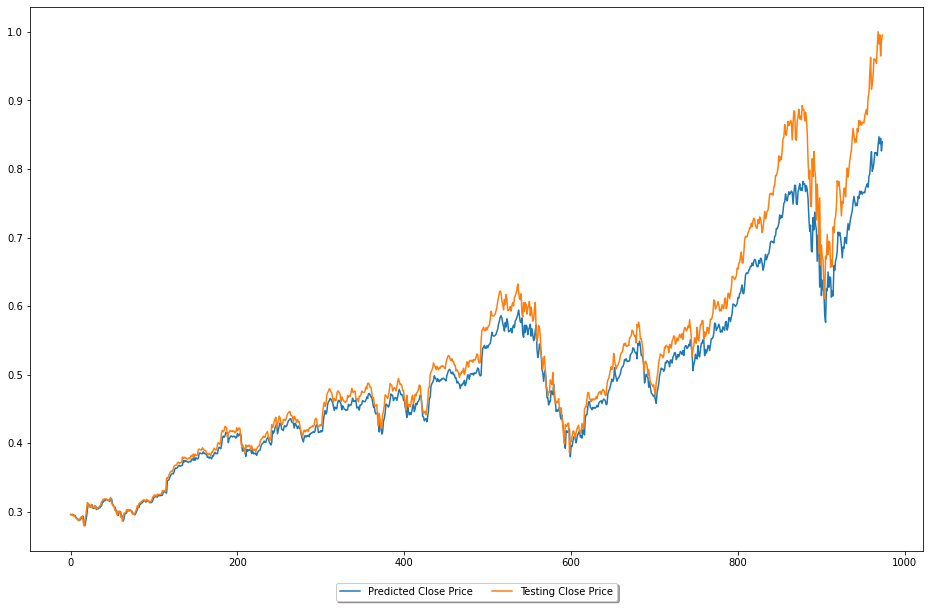

In [56]:
# plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.plot(y_test, label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()

#References

[1] https://github.com/monica110394/Stock-Market-Prediction/blob/main/stock_market_prediction.ipynb

[2] https://towardsdatascience.com/my-absolute-go-to-for-sentiment-analysis-textblob-3ac3a11d524

[3] https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b
